In [272]:
from sys import path
from importlib import reload
import matplotlib.colors as mcolors
COLORS = list(mcolors.TABLEAU_COLORS.keys())
path.append('..')  # Go up one directory to where utils.py is located


In [273]:
import deeponet_utils, symp_utils
import symp_utils 
reload(deeponet_utils)
reload(symp_utils)
from deeponet_utils import *
from symp_utils import *


In [274]:
def analytic_solution(iv, t):
    
    N = iv.shape[-1] // 2
    
    t = t[None,:,None, None]
    iv = iv[:,None,...]
    

    q = iv[...,1:N]
    p = iv[...,N+1:]    
    
    
    q0 = iv[...,None,0]
    p0 = iv[...,None,N]
    
    
        
    k = torch.arange(1, N)[None,None,None,:]
   
    q_new = q * torch.cos(2 * torch.pi * k * t) + p * torch.sin(2 * torch.pi * k * t) / (2 * torch.pi * k)
    p_new = p * torch.cos(2 * torch.pi * k * t) - q * torch.sin(2 * torch.pi * k * t) * (2 * torch.pi * k)
        
    q0_new = q0 + p0 * t
    p0_new = p0 * torch.ones_like(t)

    
    y = torch.cat((q0_new, q_new, p0_new, p_new), axis=-1)    
    
    
    return y
        
        
    


In [275]:
def get_data(num_iv=10, num_t=10,  N=10, Tmax=1):
    
    iv = 2*torch.rand(size=(num_iv, 1, 2*N), dtype=torch.float32) - 1
    
    
    if num_t > 1:
        t = Tmax * torch.rand(size=(num_t), dtype=torch.float32)
    else:
        t = torch.tensor([Tmax], dtype=torch.float32)
    
    y = analytic_solution(iv, t)
    
    if num_t > 1:
        X = (iv, t[:,None])
    else:
        y = (y[...,:N].squeeze(1), y[...,N:].squeeze(1))
        X = (iv[...,:N], iv[...,N:])
    
    return X, y

In [276]:
N, h = 8, 1e-3
X_train, y_train = get_data(num_iv=100, num_t=1, Tmax=h, N=N)
X_test, y_test = get_data(num_iv=100, num_t=1, Tmax=h, N=N)


print(*(torch.mean(torch.linalg.norm(y_train[i]-X_train[i])) for i in range(2)))

tensor(0.0179) tensor(15.9811)


Step 	 Train loss 	 Test loss
1000 	 [9.95e-03] 	 [1.65e-02] 	 New best model!
2000 	 [3.42e-03] 	 [9.40e-03] 	 New best model!
3000 	 [1.54e-03] 	 [6.76e-03] 	 New best model!
4000 	 [6.89e-04] 	 [5.03e-03] 	 New best model!
5000 	 [1.05e-03] 	 [3.95e-03] 	 New best model!
6000 	 [1.64e-04] 	 [3.09e-03] 	 New best model!
7000 	 [5.50e-04] 	 [2.61e-03] 	 New best model!
8000 	 [1.23e-02] 	 [1.53e-02] 	 
9000 	 [7.48e-05] 	 [2.26e-03] 	 New best model!
10000 	 [5.01e-04] 	 [2.47e-03] 	 
Best testing loss: 0.0022631490137428045


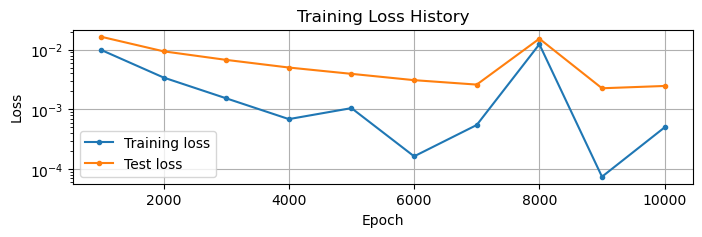

In [277]:
width, depth = 30, 3
net = SympNet(depth*[width], N=N, h=h, activation='relu')
model = SympModel(X_train, y_train, X_test, y_test, net)
model.train(iterations=10000)
model.plot_losshistory()

In [278]:
def test_symplecticity(model, T=1, num_pts=100):

                
                
    I = torch.eye(N)
    O = torch.zeros_like(I)

    J = torch.cat([torch.cat([O, I], dim=1), torch.cat([-I, O], dim=1) ], dim=0)
                
    X, _ = get_data(num_iv=num_pts, num_t=1, Tmax=0.01, N=N)

    X = tuple(x.requires_grad_(True) for x in X)
    
    q, p = model.net(*X)
    
    u = torch.cat((q, p), axis=-1).squeeze(1)    
                
    D = torch.stack([torch.cat(grad(u[:,i], X, grad_outputs=torch.ones_like(u[:,i]), retain_graph=True), axis=-1) 
                     for i in range(u.shape[-1])], axis=-1).squeeze(1)
        
    DTJD = torch.matmul(D.transpose(1, 2), torch.matmul(J, D))      
    deltaJ = torch.linalg.norm(DTJD - J, ord=2, dim=(1, 2)).numpy().mean()
    
    return deltaJ
    
dJ = test_symplecticity(model, T=h, num_pts=1)
print("Average deviance", dJ)

Average deviance 1.4369182e-07


In [279]:
'''GENERATE PREDICTIONS'''
iters = int(1 / h)
T = h * (iters+1)
t = np.linspace(0, T, iters+2)[:-1]
h_tensor = torch.tensor([[h]], dtype=torch.float32)


M = 2*N
x = torch.tensor(np.linspace(0, 1, M-2, endpoint=False), dtype=torch.float32)

u = torch.sin(2 * np.pi * x) + torch.sin(4*np.pi*x) / 2


q0 = torch.real(torch.fft.rfft(u))
p0 = torch.zeros_like(q0)


pred_q, pred_p = model.predict((q0, p0), h) 
pred_u, pred_ut = torch.fft.irfft(pred_q), torch.fft.irfft(pred_p)


X = x.numpy()

In [280]:
'''GENERATE ANALYTICAL SOLUTIONS'''
a = lambda x, t: np.sin(2 * np.pi * x) * np.cos(2 * np.pi * t) + np.sin(4 * np.pi * x) * np.cos(4 * np.pi * t) / 2
b = lambda x, t : - 2 * np.pi * np.sin(2 * np.pi * x) * np.sin(2 * np.pi * t) - 2 * np.pi * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * t)
analytic_u = a(x[None,:].numpy(), t[:,None])
analytic_ut = b(x[None,:].numpy(), t[:,None])

IndexError: too many indices for tensor of dimension 1

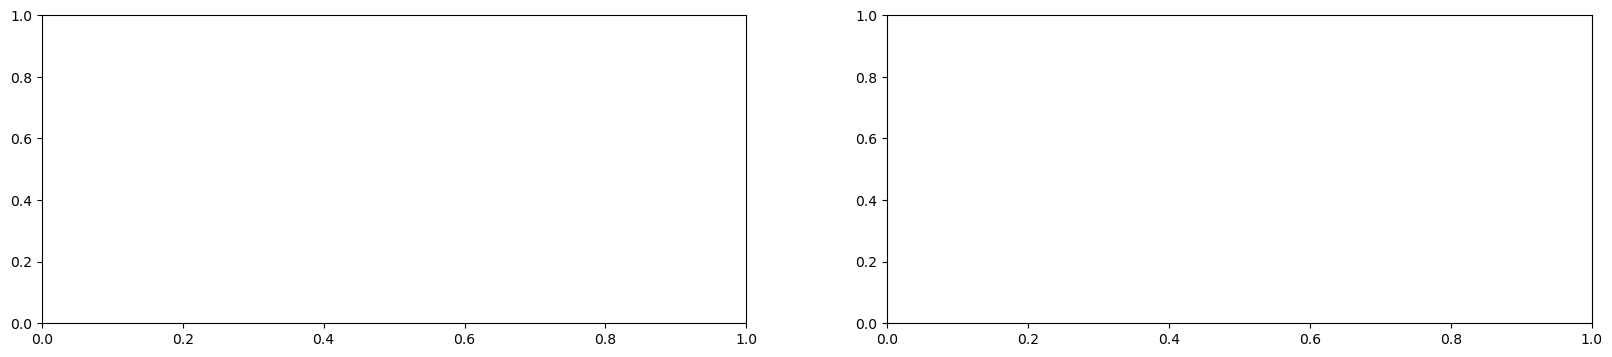

In [281]:
'''ANIMATE PREDICTION VS. SOLUTION'''
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML  # For rendering animations in Jupyter

step = int(0.01 / h)


# Set up the figure and axis for plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
line1, = ax[0].plot(X, pred_u[0,:].detach().numpy(), '--', c='k')
line2, = ax[0].plot(X, analytic_u[0,:], c='orange', linewidth=10, alpha=0.3)
line3, = ax[1].plot(X, pred_ut[0,:].detach().numpy(), '--', c='k')
line4, = ax[1].plot(X, analytic_ut[0,:], c='green', linewidth=10, alpha=0.3)
time_text = ax[0].text(0.75, 1.07, f't={0}', transform=ax[0].transAxes, fontsize=12)

handles = [line2, line4, line1]
labels = ['$u$', '$u_t$', 'prediction']
fig.legend(handles, labels, loc="upper center", ncol=len(labels), fontsize=10)

ax[0].set_ylim(-1.5, 1.5) 
ax[1].set_ylim(-10, 10)

# Define the update function for the animation
def update(frame):
    line1.set_ydata(pred_u[step*frame,:].detach().numpy())
    line2.set_ydata(analytic_u[step*frame,:])
    line3.set_ydata(pred_ut[step*frame,:].detach().numpy())
    line4.set_ydata(analytic_ut[step*frame,:])
    time_text.set_text(f't={step*frame*h:.2f}')  # Update the timer text

    return (line1, line2, line3, line4, time_text)

# Create the animation object
ani = FuncAnimation(fig, update, frames=pred_u.shape[0] // step, interval=50, blit=True)
# Display the animation inline in the notebook

plt.close(fig)

HTML(ani.to_jshtml())
